## Setup logging

In [2]:
from IPython.display import clear_output
import logging
from ipylogging import DisplayHandler, HTMLFormatter

handler = DisplayHandler()
handler.setFormatter(HTMLFormatter())

log = logging.getLogger()
log.addHandler(handler)
log.setLevel(logging.INFO)

## Importing dataset and modules

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from minirig import load_csv_dataset, save_csv_dataset
import os
import json

data_dir = Path('../data')
bots_dataset_path = data_dir.joinpath('bots-dataset.csv')
bots_issues_dir = data_dir.joinpath('bots-issues')
bot_dataset = load_csv_dataset(bots_dataset_path)

def plot_hist(data, x_label="", y_label="", title="", bins=5):
    # matplotlib histogram
    plt.hist(data, color = 'blue', edgecolor = 'black', bins=bins)

    # Add labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def get_issues_per_bot(issues_dir = None, bot = None):
    for owner in os.listdir(issues_dir.joinpath(bot)):
        for project in os.listdir(issues_dir.joinpath(bot).joinpath(owner)):
            for issue in os.listdir(issues_dir.joinpath(bot).joinpath(owner).joinpath(project).joinpath('issues')):
                issue_path = issues_dir.joinpath(bot).joinpath(owner).joinpath(project).joinpath('issues').joinpath(issue)
                with open(issue_path.joinpath('json')) as f:
                    yield [issue_path.joinpath('json'), json.load(f)]
                
    

## Filtering bots with few than 100 issues

In [8]:
filtered_bots_dataset = [x for x in bot_dataset if x['issue_count'] != 'na' and int(x['issue_count']) >= 100 and x['account'] != 'glassfishrobot']

## RQ0 - Demographics

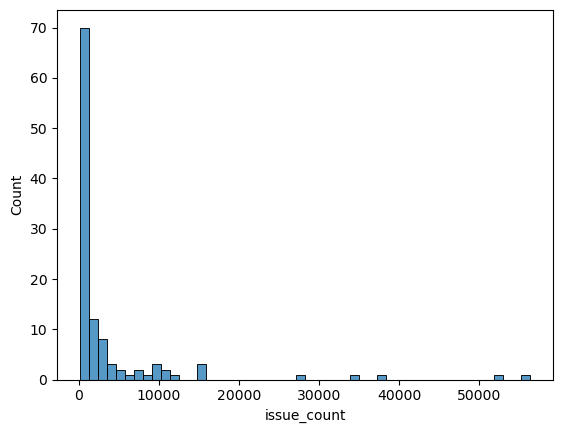

In [132]:
#Number of projects per bot
issues_per_bot = pd.DataFrame(data={'bot':[x['account'] for x in filtered_bots_dataset],'issue_count':[int(x['issue_count']) for x in filtered_bots_dataset]})
sns.histplot(issues_per_bot, x='issue_count', bins=50)
plt.savefig('../figures/rq0-issues-per-bot.pdf', bbox_inches='tight')

In [133]:
issues_per_bot.loc[issues_per_bot['issue_count'] <= 10000].count()

bot            102
issue_count    102
dtype: int64

In [134]:
issues_per_bot.loc[issues_per_bot['issue_count'] >= 50000].count()

bot            2
issue_count    2
dtype: int64

In [166]:
issues_per_bot['issue_count'].describe()

count      113.000000
mean      3905.433628
std       9138.498102
min        101.000000
25%        244.000000
50%        664.000000
75%       2588.000000
max      56400.000000
Name: issue_count, dtype: float64

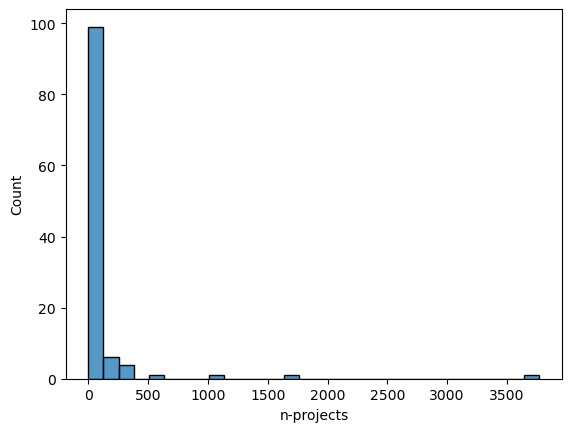

In [137]:
#Number of projects per bot
projects_per_bot = {'bot':[],'n-projects':[]}
for bot in filtered_bots_dataset:
    if bot['issue_count'] != 'na' and int(bot['issue_count']) > 0:
        n_projects = 0
        for owner in os.listdir(bots_issues_dir.joinpath(bot['account'])):
            n_projects += len(os.listdir(bots_issues_dir.joinpath(bot['account']).joinpath(owner)))
        projects_per_bot['bot'].append(bot['account'])
        projects_per_bot['n-projects'].append(n_projects)


sns.histplot(data=pd.DataFrame(data=projects_per_bot), x = 'n-projects', bins=30)
plt.savefig('../figures/rq0-projects-per-bot.pdf', bbox_inches='tight')

In [159]:
projects = pd.DataFrame(data=projects_per_bot)
len(projects.loc[projects['n-projects'] >= 500])

4

In [167]:
projects['n-projects'].describe()

count     113.000000
mean      102.778761
std       401.579309
min         1.000000
25%         6.000000
50%        16.000000
75%        52.000000
max      3771.000000
Name: n-projects, dtype: float64

## RQ1 - What is the proportion of sections with TD in issues which involves bots?

In [5]:
from model_li2022_emse import *

model1_li2022_emse = Model1_IssueTracker_Li2022_ESEM('../model/mode1-issue-tracker-li2022-emse/model1-issue-tracker-li2022-esem-weight_file.hdf5', 
                 '../model/mode1-issue-tracker-li2022-emse/model1-issue-tracker-li2022-esem-word_embedding_file.bin')

Loading model ../model/mode1-issue-tracker-li2022-emse/model1-issue-tracker-li2022-esem-weight_file.hdf5...


In [ ]:
for bot in filtered_bots_dataset:
    cnt = 1
    for issue in get_issues_per_bot(bot=bot['account'], issues_dir = bots_issues_dir):
        try:
            issue[1]['td-label-li2022-emse'] = model1_li2022_emse.predict(issue[1]['body'])
        except:
            pass
        with open(issue[0], 'w') as f:
            json.dump(issue[1], f)
        clear_output()
        log.info(f'{bot["account"]} - Handling {cnt} out {bot["issue_count"]} issues')
        cnt += 1